### 회선
- 마스크 내의 원소값과 공간 영역에 있는 입력 영상의 화소값들을 대응되게 곱하여 출력 화소값을 계산
- 픽셀 영역 처리
- 마스크의 크기는 홀수개로 잡음(그래야 가운데 값을 연산할 수 있음)

### 블러링 현상
- 디지털 카메라로 사진 찍을 때, 초점이 맞지 않으면 $\to$ 사진 흐려짐
- 이러한 현상을 이용해 영상의 디테일한 부분을 제거하는 아웃 포커싱(out focusing) 기법
  - 포토샵을 이용한 '뽀샵'
  - 사집 편집앱의 '뽀샤시' 기능

### 블러링
- 영상에서 화소값이 급격하게 변하는 부분들을 감소시켜서 점진적으로 변하게 함으로써 양상이 전체적으로 부드러운 느낌이 나게 하는 기술
- 블러링 마스크<br>
  3x3, 5x5 $\to$ 마스크는 일반적으로 홀수개, 모든 값을 다 더해서 1이 되어야 함

In [6]:
import numpy as np, cv2, time

# 회선 수행 함수 - 행렬 처리 방식(속도 면에서 유리)
def filter(image, mask):
    rows, cols = image.shape[:2]
    dst = np.zeros((rows, cols), np.float32)                 # 회선 결과 저장 행렬
    xcenter, ycenter = mask.shape[1]//2, mask.shape[0]//2  # 마스크 중심 좌표

    for i in range(ycenter, rows - ycenter):                  # 입력 행렬 반복 순회
        for j in range(xcenter, cols - xcenter):
            # 마스크의 크기 지정(3x3)
            y1, y2 = i - ycenter, i + ycenter + 1               # 관심영역 높이 범위
            x1, x2 = j - xcenter, j + xcenter + 1               # 관심영역 너비 범위
            roi = image[y1:y2, x1:x2].astype("float32")         # 관심영역 형변환

            tmp = cv2.multiply(roi, mask)                       # 회선 적용 - OpenCV 곱셈
            # [0] 인 이유: grayscale이기 때문, 만약 color라면 3개를 가져와야 함
            dst[i, j] = cv2.sumElems(tmp)[0]                    # 출력화소 저장(2장 or 3장, 배열 내 요소들을 모두 더함)
    return dst                                                  # 자료형 변환하여 반환

# 회선 수행 함수 - 화소 직접 근접
def filter2(image, mask):
    rows, cols = image.shape[:2]
    dst = np.zeros((rows, cols), np.float32)                 # 회선 결과 저장 행렬
    xcenter, ycenter = mask.shape[1]//2, mask.shape[0]//2  # 마스크 중심 좌표

    # 파이썬의 문법 이용
    for i in range(ycenter, rows - ycenter):                  # 입력 행렬 반복 순회
        for j in range(xcenter, cols - xcenter):
            sum = 0.0
            for u in range(mask.shape[0]):                    # 마스크 원소 순회
                for v in range(mask.shape[1]):
                    y, x = i + u - ycenter , j + v - xcenter
                    sum += image[y, x] * mask[u, v]           # 회선 수식
            dst[i, j] = sum
    return dst

def filter3(image, mask):
    rows, cols = image.shape[:2]
    dst = np.zeros((rows, cols), np.float32)                 # 회선 결과 저장 행렬
    xcenter, ycenter = mask.shape[1]//2, mask.shape[0]//2  # 마스크 중심 좌표

    # 파이썬의 문법 이용
    for i in range(ycenter, rows - ycenter):                  # 입력 행렬 반복 순회
        for j in range(xcenter, cols - xcenter):
            sum = 0.0
            for u in range(-ycenter, ycenter+1):                    # 마스크 원소 순회
                for v in range(-ycenter, ycenter+1):
                    # y, x = i + u - ycenter , j + v - xcenter      # 이 연산을 하지 않아도 됨
                    sum += image[i + u, j +v] * mask[u + ycenter, v + xcenter]           # 회선 수식
            dst[i, j] = sum
    return dst

image = cv2.imread("images/filter_blur.jpg", cv2.IMREAD_GRAYSCALE)  # 영상 읽기
if image is None: raise Exception("영상파일 읽기 오류")

# 블러링 마스크 원소 지정     
data = [1/9, 1/9, 1/9,
        1/9, 1/9, 1/9,
        1/9, 1/9, 1/9]

mask = np.array(data, np.float32).reshape(3, 3)
# mask = mp.ones((3,3)) / 9     # 위 코드와 동일함
start = time.time()
blur1 = filter(image, mask)                                    # 회선 수행 - 화소 직접 접근
print('filter1: ', time.time() - start)

start = time.time()
blur2 = filter2(image, mask)                                   # 회선 수행
print('filter2: ', time.time() - start)

start = time.time()
blur3 = filter3(image, mask)
print('filter3: ', time.time() - start)

start = time.time()
blur4 = cv2.filter2D(image, -1, mask)
print('filter4: ', time.time() - start)


cv2.imshow("image", image)
cv2.imshow("blur1", blur1.astype("uint8"))
cv2.imshow("blur2", cv2.convertScaleAbs(blur2))
cv2.imshow("blur3", cv2.convertScaleAbs(blur3))
cv2.imshow("blur4", blur4)
cv2.waitKey(0)
cv2.destroyAllWindows()

filter1:  1.538508415222168
filter2:  0.8990452289581299
filter3:  0.8060929775238037
filter4:  0.013974666595458984


In [5]:
import cv2
import numpy as np

file_name = 'images/filter_blur.jpg'
img = cv2.imread(file_name)

blur1 = cv2.blur(img, (3,3))
blur2 = cv2.boxFilter(img, -1, (10,10))

merged = np.hstack((img, blur1, blur2))
cv2.imshow('blur', merged)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 가우시안 블러링
- 원래 픽셀의 정보를 더 집어넣음 $\to$ 가우시안은 부드럽게만 함, 전체적으로 덜 흐리게 해줌
- 목적에 따라 박스필터보다 가우시안 블러링이 더 좋을 수도 있음(ex. 뽀샵)

In [ ]:
import cv2
import numpy as np

img = cv2.imread('images/filter_blur.jpg')

k1 = np.array([[1,2,1],
               [2,4,2],
               [1,2,1]]) * (1/16)

### 미디언 블러링
- 픽셀 값 중에 중간 값을 대상 픽셀의 값으로 선택함
- 커널 크기가 작아지면 큰 노이즈는 남게 됨

### 샤프닝
- 입력 화소에서 이웃 화소끼리 차이를 크게 되도록

### 샤프닝 마스크
- 마스크 원소들의 값 차이가 커지도록 구성
- 마스크 원소 전체 합이 1이 되어야 입력영상 밝기가 손실 없이 출력영상 밝기로 유지

In [9]:
import numpy as np, cv2
from Common.filters import filter

image = cv2.imread("images/filter_sharpen.jpg", cv2.IMREAD_GRAYSCALE) # 영상 읽기
if image is None: raise Exception("영상파일 읽기 오류")

# 샤프닝 마스크 원소 지정 
data1 = [0, -1, 0,
        -1, 5, -1,
         0, -1, 0]
data2 = [[-1, -1, -1],
         [-1, 9, -1],
         [-1, -1, -1]]
mask1 = np.array(data1, np.float32).reshape(3, 3)
mask2 = np.array(data2, np.float32)

sharpen1 = filter(image, mask1)                     # 회선 수행 – 저자 구현 함
sharpen2 = filter(image, mask2) 
sharpen1 = cv2.convertScaleAbs(sharpen1)
sharpen2 = cv2.convertScaleAbs(sharpen2)

cv2.imshow("image", image)
cv2.imshow("sharpen1", sharpen1)  # 윈도우 표시 위한 형변환
cv2.imshow("sharpen2", cv2.convertScaleAbs(sharpen2))
cv2.waitKey(0)
cv2.destroyAllWindows()

### 언샤프 마스크(Unsharp mask)
- 날카롭지 않은 영상, 즉 부드러워진 영상을 이용

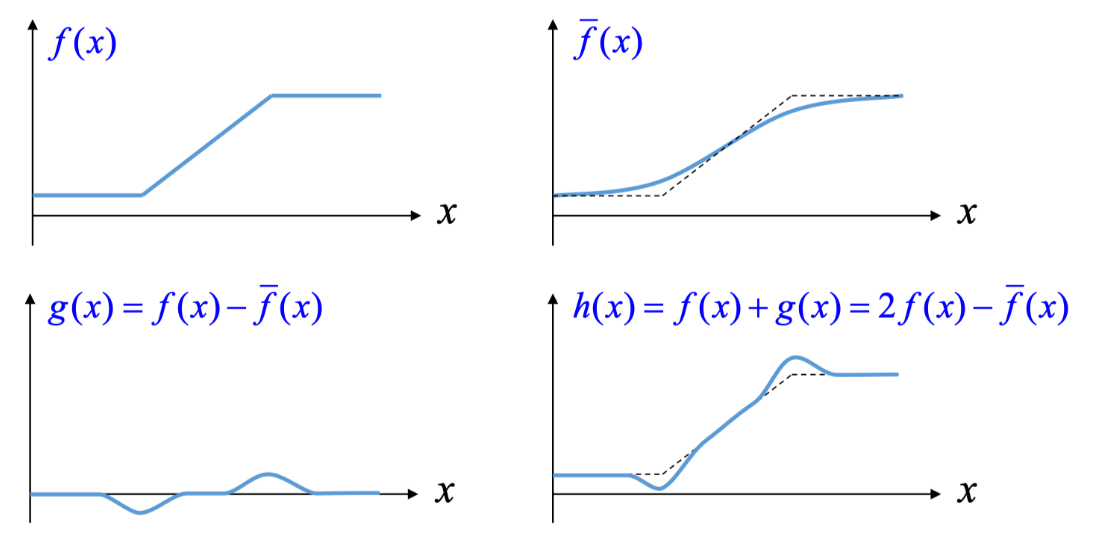
- 언샤프 마스크 필터링 과정

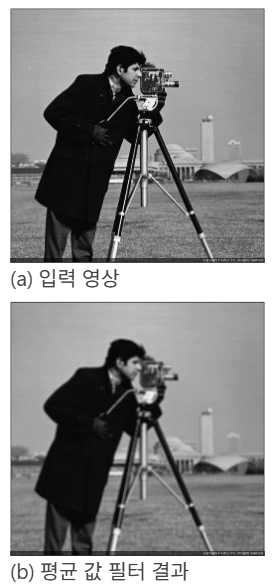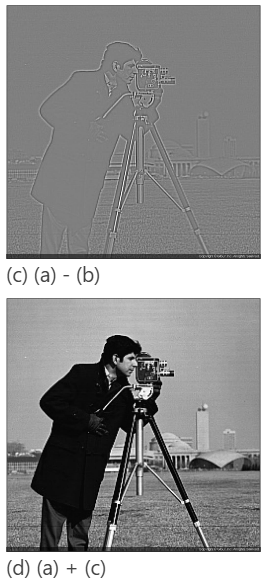
- 샤프닝과 비교했을 때 블러링이 발생하지 않음

- unsharp mask 프로그래밍
  - opencv를 통해 계산한 것과 수식 계산의 서순은 동일하지만 값이 나오진 않음

### 라플라시안 필터를 이용한 언샤프 마스크

### 에지 검출
- 에지(edge): 가장자리, 모서리 $\to$ 윤곽선, 경계선 $\to$ "화소값이 급격하게 변화하는 부분"
- 에지 검출 $\to$ 객체의 크기, 위치, 모양 등을 찾기 위한 기본적인 처리
- 영상을 인식(이해)하는데 더 큰 목적 $\to$ 이에 기초가 되는 것이 엣지 검

## 1차 미분 마스크
### 미분
- 에지가 화소의 밝기가 급격히 변하는 부분이기 때문에 함수의 변화율을 취하는 미분 연산을 이용해서 에지 검출 가능

### 밝기의 변화율음 검출하는 방법
- 밝기에 대한 기울기 계산

### 로버츠 에지 검출
- 4x4(값 2개)
  - 0 -1<br>
    1  0
  - -1 0<br>
     0 1 

### 프리윗 마스크
- 9x9(값 3개))
  - -1 -1 -1<br>
    0 $\;$ 0 $\;$ 0<br>
    1 $\;$ 1 $\;$ 1

### 소벨 마스크
- 9x9(값 3개)
  - -1 -2 -1<br>
    0 $\;$ 0 $\;$ 0<br>
    1 $\;$ 2 $\;$ 1

### 샤르(scharr) 필터
- 아주 자세한 경계를 찾고 싶을 때 사용

## 2차 미분 마스크
### 라플라시안 필터
- 합이 0
- 미분을 2번하기 때문에 방향성이 없음

### LoG(Laplacian of Gaussian), Dog(Difference of Gaussian)
- 둘의 결과는 비슷
- Dog가 계산이 더 간단

### 케니 에지 검출
- 

In [9]:
import numpy as np, cv2
from Common.utils import ck_time
def nonmax_suppression(sobel, direct):
    rows, cols = sobel.shape[:2]
    dst = np.zeros((rows, cols), np.float32)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # 행렬 처리를 통해 이웃 화소 가져오기
            values = sobel[i-1:i+2, j-1:j+2].flatten()
            first = [3, 0, 1, 2]
            id = first[direct[i, j]]
            v1, v2 = values[id], values[8-id]

            ## if 문으로 이웃 화소 가져오기
            # if direct[i, j] == 0: # 기울기 방향 0도
            #     v1, v2 = sobel[i, j-1], sobel[i, j+1]
            # if direct[i, j] == 1: # 기울기 방향 45도
            #     v1, v2 = sobel[i-1, j-1], sobel[i+1, j+1]
            # if direct[i, j] == 2: # 기울기 방향 90도
            #     v1, v2 = sobel[i-1, j], sobel[i+1, j]
            # if direct[i, j] == 3: # 기울기 방향 135도
            #     v1, v2 = sobel[i+1, j-1], sobel[i-1, j+1]

            dst[i, j] = sobel[i, j] if (v1 < sobel[i , j] > v2) else 0
    return dst

def nonmax_suppression1(sobel, direct):
    rows, cols = sobel.shape[:2]
    dst = np.zeros((rows, cols), np.float32)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            values = sobel[i-1:i+2, j-1:j+2].flat
            max = np.max(values)
            dst[i, j] = sobel[i, j] if sobel[i , j] >= max else 0
    return dst

def trace(max_sobel, i, j, low):
    h, w = max_sobel.shape
    if (0 <= i < h and 0 <= j < w) == False: return  # 추적 화소 범위 확인
    if pos_ck[i, j] == 0 and max_sobel[i, j] > low:
        pos_ck[i, j] = 255
        canny[i, j] = 255
        trace(max_sobel, i - 1, j - 1, low)# 추적 함수 재귀 호출 - 8방향 추적
        trace(max_sobel, i    , j - 1, low)
        trace(max_sobel, i + 1, j - 1, low)
        trace(max_sobel, i - 1, j    , low)
        trace(max_sobel, i + 1, j    , low)
        trace(max_sobel, i - 1, j + 1, low)
        trace(max_sobel, i    , j + 1, low)
        trace(max_sobel, i + 1, j + 1, low)

def hysteresis_th(max_sobel, low, high):                # 이력 임계값 수행
    rows, cols = max_sobel.shape[:2]
    for i in range(1, rows - 1):  # 에지 영상 순회
        for j in range(1, cols - 1):
            if max_sobel[i, j] > high:  trace(max_sobel, i, j, low)  # 추적 시작

image = cv2.imread("images/canny.jpg", cv2.IMREAD_GRAYSCALE)
if image is None: raise Exception("영상 파일 읽기 오류")
pos_ck = np.zeros(image.shape[:2], np.uint8)
canny = np.zeros(image.shape[:2], np.uint8)

# 사용자 정의 캐니 에지
gaus_img = cv2.GaussianBlur(image, (5, 5), 0.3)
Gx = cv2.Sobel(np.float32(gaus_img), cv2.CV_32F, 1, 0, 3)  # x방향 마스크
Gy = cv2.Sobel(np.float32(gaus_img), cv2.CV_32F, 0, 1, 3)  # y방향 마스크
#sobel = cv2.magnitude(Gx, Gy)                            # 두 행렬 벡터 크기
sobel = np.fabs(Gx) + np.fabs(Gy)                       # 두 행렬 절댓값 덧셈
directs = cv2.phase(Gx, Gy) / (np.pi / 4)
directs = directs.astype(int) % 4
max_sobel = nonmax_suppression(sobel, directs)   # 비최대치 억제
hysteresis_th(max_sobel, 100, 150)          # 이력 임계값
canny2 = cv2.Canny(image, 100, 150)                 # OpenCV 캐니 에지

cv2.imshow("image", image)
cv2.imshow("canny", canny)                 # 사용자 정의 캐니
cv2.imshow("OpenCV_Canny", canny2)           # OpenCV 캐니 에지
cv2.waitKey(0)
cv2.destroyAllWindows()